<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/gen_soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

In [ ]:
# imputed SOC dostributions
file_path = '/content/drive/MyDrive/hawaii_soils/HI soils data/annotated_combo_imputed_SOC.gpkg'

gdf = gpd.read_file(file_path)

In [ ]:
def preprocess_and_train_model(matched_data):
    # Data Preprocessing Steps
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    # Model Definition
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')  # Adjust output layer according to your needs
        ])
        return model

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Training:Testing 80:20 ratio
    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)

    # Predictions and Evaluation
    predictions = model.predict(X_test).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y_test
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    r_squared = r2_score(inversed_truth, inversed_predictions)

    return model, test_loss, r_squared, inversed_predictions, inversed_truth, scaler, X_test, y_test



Sequential NN model definition for the above model: Dense layers with increasing number of neurons (256, 512, 1024).
BatchNormalization layers to stabilize learning by normalizing inputs to each layer.
LeakyReLU activation functions with an alpha of 0.2 to avoid dead neurons.
Dropout layers with a dropout rate of 0.3 to prevent overfitting.
Output layer with a single neuron and a linear activation function, suitable for regression tasks.

Revised model evaluation below

revised predict on new data

In [ ]:
def predict_on_reserve(matched_data, model, scaler):
    # Data Preprocessing Steps
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 55]
    numeric_cols = matched_data.iloc[:, keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), X.shape[1] + 1), fill_value=0.5)  # Adjust to the correct shape
    dummy_array[:, :-1] = X
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] = inversed_truth.flatten()

    # Evaluate predictions
    r_squared = r2_score(inversed_truth, inversed_predictions)
    mae = mean_absolute_error(inversed_truth, inversed_predictions)
    rmse = mean_squared_error(inversed_truth, inversed_predictions, squared=False)

    print("R-Squared Score:", r_squared)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inversed_truth, y=inversed_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.plot([min(inversed_truth), max(inversed_truth)], [min(inversed_truth), max(inversed_truth)], 'r')
    plt.show()

    # Residual plot
    residuals = inversed_truth - inversed_predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Distribution of Residuals")
    plt.show()

    return matched_data

# Example call to the function
# matched_data_predictions = predict_on_reserve(matched_data, model, scaler)



In [ ]:
def evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth):
    test_loss = model.evaluate(X_test, y_test)
    r_squared = r2_score(inversed_truth, inversed_predictions)

    print("Test Loss:", test_loss)
    print("R-Squared Score:", r_squared)

    mae = mean_absolute_error(inversed_truth, inversed_predictions)
    rmse = mean_squared_error(inversed_truth, inversed_predictions, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inversed_truth, y=inversed_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.plot([min(inversed_truth), max(inversed_truth)], [min(inversed_truth), max(inversed_truth)], 'r')  # Diagonal line
    plt.show()

    # Residual plot
    residuals = inversed_truth - inversed_predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Distribution of Residuals")
    plt.show()

# Assuming model, test_loss, r_squared, inversed_predictions, inversed_truth, X_test, and y_test are already computed
# model, test_loss, r_squared, inversed_predictions, inversed_truth, scaler, X_test, y_test = preprocess_and_train_model(matched_data)
# evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth)




previous prediction on new data below

In [ ]:
def predict_on_reserve(matched_data,model,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] =inversed_truth.flatten()
    return matched_data

In [ ]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [ ]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [ ]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [ ]:
# Filter the DataFrame using .loc
soils_csv = soils_csv.loc[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]

# Create geometry column
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)

# Convert to GeoDataFrame
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")


In [ ]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [ ]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', predicate='intersects')


In [ ]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


In [ ]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)

prediction_list = []

for i in range(10):
  matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, inversed_predictions, inversed_truth, scaler, X_test, y_test = preprocess_and_train_model(matched_data)

  predictions = predict_on_reserve(reserve_data, model, scaler)
  prediction_list.append(predictions)



<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 70ms/step - loss: 1.8910 - val_loss: 0.0215
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.2239 - val_loss: 0.0217
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2131 - val_loss: 0.0275
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2324 - val_loss: 0.0297
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.9052 - val_loss: 0.0294
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4894 - val_loss: 0.0287
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.9272 - val_loss: 0.0296
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7865 - val_loss: 0.0273
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4092 - val_loss: 0.0276
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2138 - val_loss: 0.0257
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 2.6921 - val_loss: 0.0292
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.4824 - val_loss: 0.0298
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8754 - val_loss: 0.0238
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8449 - val_loss: 0.0285
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4015 - val_loss: 0.0333
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3625 - val_loss: 0.0324
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3977 - val_loss: 0.0324
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8946 - val_loss: 0.0330
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1444 - val_loss: 0.0348
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0835 - val_loss: 0.0364
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 67ms/step - loss: 2.1785 - val_loss: 0.0210
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.1391 - val_loss: 0.0496
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.0758 - val_loss: 0.0407
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 2.2035 - val_loss: 0.0332
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7981 - val_loss: 0.0334
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 2.3058 - val_loss: 0.0370
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4900 - val_loss: 0.0341
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 2.0091 - val_loss: 0.0381
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.2669 - val_loss: 0.0375
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5504 - val_loss: 0.0349
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 67ms/step - loss: 2.4336 - val_loss: 0.0319
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1.9748 - val_loss: 0.0226
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8244 - val_loss: 0.0530
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8913 - val_loss: 0.0368
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 2.1220 - val_loss: 0.0468
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5424 - val_loss: 0.0363
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7419 - val_loss: 0.0394
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2036 - val_loss: 0.0384
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2921 - val_loss: 0.0321
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 1.5828 - val_loss: 0.0349
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 2.4106 - val_loss: 0.0744
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.5324 - val_loss: 0.0539
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.0325 - val_loss: 0.0323
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 2.1669 - val_loss: 0.0352
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2074 - val_loss: 0.0386
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8344 - val_loss: 0.0387
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5112 - val_loss: 0.0378
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1229 - val_loss: 0.0390
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.1795 - val_loss: 0.0380
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6437 - val_loss: 0.0365
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 68ms/step - loss: 1.9565 - val_loss: 0.0331
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2083 - val_loss: 0.0392
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9113 - val_loss: 0.0397
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7242 - val_loss: 0.0374
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9266 - val_loss: 0.0354
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 2.6351 - val_loss: 0.0351
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 2.1280 - val_loss: 0.0398
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.5692 - val_loss: 0.0360
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1531 - val_loss: 0.0371
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.2993 - val_loss: 0.0392
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 2.7737 - val_loss: 0.0320
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.1750 - val_loss: 0.0620
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.0763 - val_loss: 0.0436
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.9451 - val_loss: 0.0405
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8343 - val_loss: 0.0401
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4213 - val_loss: 0.0378
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8014 - val_loss: 0.0360
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0743 - val_loss: 0.0354
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0554 - val_loss: 0.0343
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.0310 - val_loss: 0.0347
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 68ms/step - loss: 2.6895 - val_loss: 0.0161
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.4457 - val_loss: 0.0366
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.7507 - val_loss: 0.0212
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5507 - val_loss: 0.0193
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7970 - val_loss: 0.0277
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4784 - val_loss: 0.0278
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6363 - val_loss: 0.0277
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.2922 - val_loss: 0.0292
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1060 - val_loss: 0.0276
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0556 - val_loss: 0.0297
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 74ms/step - loss: 2.3518 - val_loss: 0.1058
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 3.9534 - val_loss: 0.0524
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 2.3245 - val_loss: 0.0671
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 2.7558 - val_loss: 0.0375
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 2.2930 - val_loss: 0.0326
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 2.0357 - val_loss: 0.0425
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.6983 - val_loss: 0.0411
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4299 - val_loss: 0.0347
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3587 - val_loss: 0.0375
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3071 - val_loss: 0.0383
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-20-a8eb98787561>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 67ms/step - loss: 1.6510 - val_loss: 0.0674
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.2857 - val_loss: 0.0241
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 2.4315 - val_loss: 0.0322
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6939 - val_loss: 0.0458
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.5774 - val_loss: 0.0382
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4559 - val_loss: 0.0367
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6964 - val_loss: 0.0380
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.0844 - val_loss: 0.0404
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.2235 - val_loss: 0.0380
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 0.8366 - val_loss: 0.0377
Epoch 11/100
5/5 [=

<ipython-input-23-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [ ]:
combined_array = np.array([predictions['inversed_predictions'].values for predictions in prediction_list])

In [ ]:
combined_array[combined_array < 0 ] = 0

In [ ]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [ ]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [ ]:
dist_array

[array([3.03925906, 3.07331585, 3.30309937, 3.5273933 , 4.17143106,
        4.26062863, 4.36989096, 5.25334038, 5.34267054, 6.62475734]),
 array([1.28128168, 1.58189625, 1.83467051, 1.90478194, 2.2570216 ,
        2.55813864, 2.84872912, 3.15878714, 3.4604174 , 4.24392285]),
 array([ 4.53572075,  5.44312886,  6.08726988,  7.16146602,  8.4993076 ,
         9.56863138, 12.3686984 , 13.41102607, 14.35717074, 17.69878679]),
 array([ 2.69441365,  4.55054739,  5.93073903,  6.85825114,  6.91999006,
         8.17754818,  8.26092848,  9.77342672, 10.08004478, 12.28583932]),
 array([ 2.01482343,  4.37251993,  8.12147032,  8.43289673,  8.82637372,
         9.51976833, 10.9021683 , 11.30217961, 12.54537365, 16.02745145]),
 array([ 4.90212658,  5.31687957,  5.38725179,  5.72084844,  6.96506586,
         7.31030466,  7.81854272,  8.14287091,  9.90667213, 11.00375937]),
 array([ 1.4113686 ,  3.51368264,  4.37993935,  6.37773577,  8.72308563,
         9.77709966, 10.06304943, 10.53732957, 11.96522751,

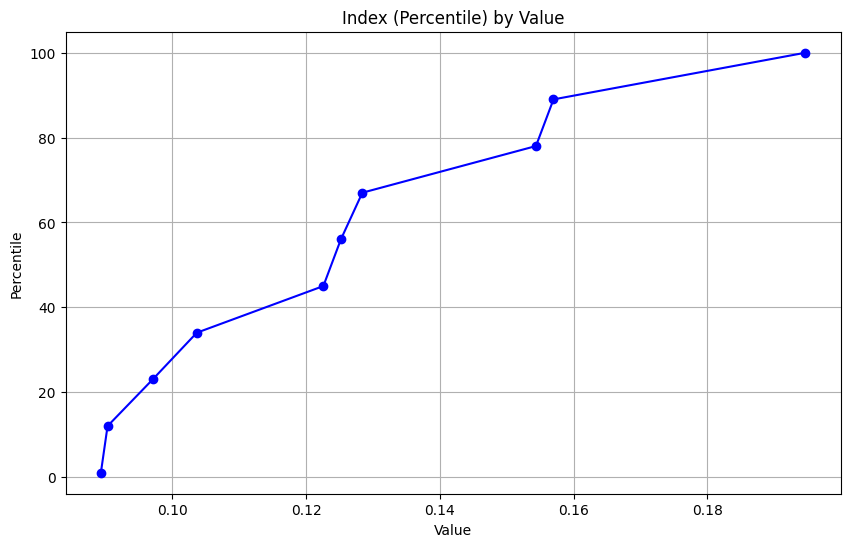

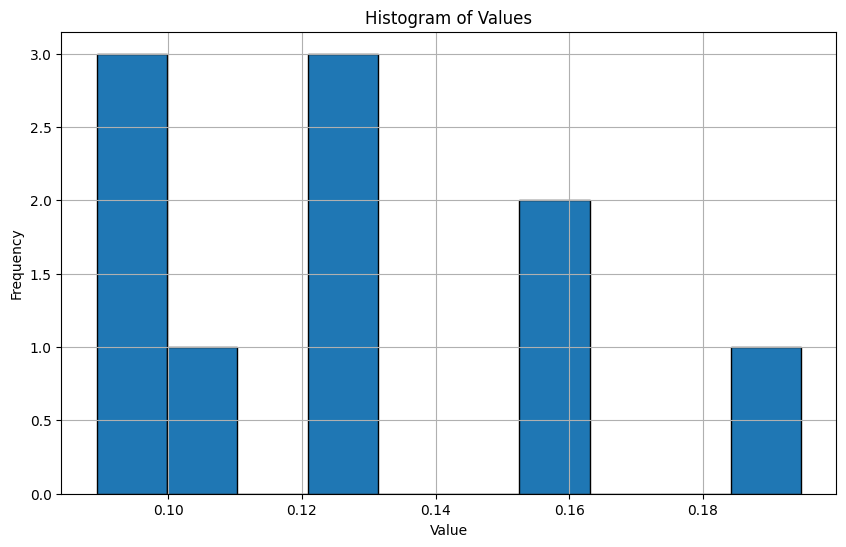

In [ ]:
array = norm_dist_array[0]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



need to check the below code block to see if "predictions" is the right data to reference (was previously coded as pred_values)

In [ ]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = predictions.iloc[:,keep_cols]

scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = predictions[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


In [ ]:
numeric_df.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'water',
       'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
       'built', 'bare', 'snow_and_ice', 'elevation', 'landform', 'SRTM_mTPI',
       'aet', 'pdsi', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn',
       'tmmx', 'vap', 'vpd', 'vs', 'agbd_m', 'norm_dist_array'],
      dtype='object')

In [ ]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')  # Adjust output layer according to your needs
    ])
    return model


In [ ]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

In [ ]:
scaled_numeric_df.dropna(inplace=True)

In [ ]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [ ]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [ ]:
y_train.shape

(599, 10)

In [ ]:
# X_test

In [ ]:
# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)
# dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
# dummy_array[:, -1] = predictions
# inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
# dummy_array[:, -1] = y_test
# inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
# r_squared = r2_score(inversed_truth, inversed_predictions)

# return model, test_loss, r_squared, inversed_predictions, scaler

Epoch 1/600
4/4 [==============================] - 2s 89ms/step - loss: 2.2802 - mae: 1.1165 - val_loss: 0.0756 - val_mae: 0.2212
Epoch 2/600
4/4 [==============================] - 0s 22ms/step - loss: 2.1019 - mae: 1.0628 - val_loss: 0.0758 - val_mae: 0.2218
Epoch 3/600
4/4 [==============================] - 0s 21ms/step - loss: 1.8721 - mae: 1.0205 - val_loss: 0.0762 - val_mae: 0.2233
Epoch 4/600
4/4 [==============================] - 0s 21ms/step - loss: 1.7337 - mae: 0.9873 - val_loss: 0.0763 - val_mae: 0.2240
Epoch 5/600
4/4 [==============================] - 0s 22ms/step - loss: 1.7719 - mae: 0.9723 - val_loss: 0.0762 - val_mae: 0.2243
Epoch 6/600
4/4 [==============================] - 0s 22ms/step - loss: 1.6455 - mae: 0.9524 - val_loss: 0.0763 - val_mae: 0.2248
Epoch 7/600
4/4 [==============================] - 0s 22ms/step - loss: 1.5427 - mae: 0.9306 - val_loss: 0.0765 - val_mae: 0.2255
Epoch 8/600
4/4 [==============================] - 0s 22ms/step - loss: 1.5583 - mae: 0.92

In [ ]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])

[0.07295437 0.08692014 0.13937335 0.08191001 0.14997002 0.12472281
 0.11114234 0.1592776  0.15154696 0.14228813]
[0.15464093 0.1633988  0.1878874  0.1880615  0.19759632 0.19862187
 0.24096818 0.27161879 0.295175   0.39554102]
[0.11707217 0.16043091 0.17914627 0.21654217 0.22648926 0.25349957
 0.18788399 0.20194751 0.2508475  0.16611686]
[0.21955983 0.22154311 0.22724715 0.22810065 0.24283096 0.24483039
 0.24999043 0.25109226 0.25189015 0.25496632]
[0.12990654 0.16165203 0.15761027 0.17148173 0.26657292 0.2630181
 0.20148064 0.20095697 0.21116382 0.22320789]
[0.20932683 0.2112552  0.21379435 0.21636718 0.21907397 0.22723322
 0.23205952 0.23463876 0.23528188 0.23827926]
[0.29668874 0.28529453 0.292486   0.27008504 0.2267341  0.2502599
 0.29360363 0.2726423  0.30075702 0.29898968]
[0.29922283 0.30220048 0.30279896 0.31458339 0.32061469 0.32325959
 0.32675778 0.32949327 0.34207461 0.37476034]
[0.11598392 0.1188724  0.15886897 0.15554944 0.17778923 0.14932086
 0.19818865 0.21428907 0.197245

Index(['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'pdsi', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m'],
      dtype='object')

ValueError: invalid literal for int() with base 10: 'water'

In [ ]:
def normal_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.normal(variable_mean, variable_sd, n)

def uniform_generator(n, min_val, max_val, min_variation, max_variation):
    variable_min = min_val + np.random.uniform(-min_variation * 2, min_variation * 2)
    variable_max = max_val + np.random.uniform(-max_variation * 2, max_variation * 2)
    return np.random.uniform(variable_min, variable_max, n)

def right_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.lognormal(variable_mean, variable_sd, n)

def left_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return -np.random.lognormal(variable_mean, variable_sd, n)

def multimodal_generator(ns, means, sds, mean_variation, sd_variation):
    samples_list = []
    for i in range(len(means)):
        variable_mean = means[i] + np.random.normal(0, mean_variation * 2)
        variable_sd = sds[i] + abs(np.random.normal(0, sd_variation * 2))
        samples_list.append(np.random.normal(variable_mean, variable_sd, ns[i]))
    return np.concatenate(samples_list)

In [ ]:
def rescale_to_minus_one_one(values):
    min_value = np.min(values)
    max_value = np.max(values)
    scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1
    return scaled_values

In [ ]:
def generate_samples(n, q, generator_func, *args):
    samples = generator_func(n, *args)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)

def generate_normal_samples(n=10000, q=10, mean_value=0, sd_value=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, normal_generator, mean_value, sd_value, mean_variation, sd_variation)

def generate_uniform_samples(n=10000, q=10, min_value=-1, max_value=1, min_variation=0.5, max_variation=0.5):
    return generate_samples(n, q, uniform_generator, min_value, max_value, min_variation, max_variation)

def generate_right_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, right_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_left_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, left_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_multimodal_samples(ns=[1000, 50], q=10, means=[1, -1], sds=[1, 0.5], mean_variation=0.5, sd_variation=0.5):
    samples = multimodal_generator(ns, means, sds, mean_variation, sd_variation)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)


In [ ]:
def generate_training_data(n_samples=10000):
    data_list = {}

    # Generate samples for each distribution type
    data_list['normal'] = [generate_normal_samples() for _ in range(n_samples)]
    data_list['bimodal'] = [generate_multimodal_samples() for _ in range(n_samples)]
    data_list['uniform'] = [generate_uniform_samples() for _ in range(n_samples)]
    data_list['right_tailed'] = [generate_right_tailed_samples() for _ in range(n_samples)]
    data_list['left_tailed'] = [generate_left_tailed_samples() for _ in range(n_samples)]

    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame()
    for name, samples_list in data_list.items():
        df = pd.DataFrame(samples_list)
        df['label'] = name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

    # Assign column names
    combined_data.columns = [f'V{i+1}' for i in range(combined_data.shape[1] - 1)] + ['label']

    return combined_data

In [ ]:
training_data = generate_training_data()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Separate features and labels
X = training_data.drop(columns=['label'])
y = training_data['label']

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, min_samples_leaf=2, random_state=123)

# Train the model
rf_model.fit(X, y_encoded)

# Print the trained model
print(rf_model)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500,
                       random_state=123)


In [ ]:
reference_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  y_test]

In [ ]:
# reference_rf_ready_predictions

In [ ]:
some_new_data = training_data = generate_training_data()

In [ ]:
# predictions

In [ ]:
prediction_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  predictions]

In [ ]:
real_quantiles.columns = [f'V{i+1}' for i in range(real_quantiles.shape[1])]

In [ ]:
real_data_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  np.array(real_quantiles) ]

<ipython-input-43-1fd1295b8291>:4: RuntimeWarning: divide by zero encountered in divide
  scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1
<ipython-input-43-1fd1295b8291>:4: RuntimeWarning: invalid value encountered in divide
  scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1


In [ ]:
# Assuming real_data_rf_ready_predictions is your list of predictions
real_data_rf_ready_predictions = [prediction for prediction in real_data_rf_ready_predictions if not np.any(np.isnan(prediction))]


In [ ]:
real_data_rf_ready_predictions

[array([-1.        , -0.98717755, -0.92093098, -0.79561418, -0.62700589,
        -0.26232321,  0.01969454,  0.59533756,  0.93023531,  1.        ]),
 array([-1.        , -0.67560193, -0.5816494 , -0.48919493, -0.44787044,
        -0.40070133,  0.33199473,  0.75614019,  0.8551365 ,  1.        ]),
 array([-1.        , -0.77777778, -0.55555556, -0.55555556, -0.55555556,
        -0.55555556, -0.33333333, -0.33333333, -0.0617284 ,  1.        ]),
 array([-1.        , -1.        , -0.57507686, -0.34411538, -0.15612878,
         0.17798977,  0.32363339,  0.43311027,  0.92384591,  1.        ]),
 array([-1.        , -0.49291043, -0.04328356,  0.04664181,  0.17476263,
         0.22649256,  0.45454545,  0.52265951,  0.72727273,  1.        ]),
 array([-1.00000000e+00, -4.28571429e-01, -2.85714286e-01, -2.85714286e-01,
        -1.42857143e-01, -1.42857143e-01,  2.22044605e-16,  2.22044605e-16,
         1.42857143e-01,  1.00000000e+00]),
 array([-1.        ,  0.22988475,  0.22988475,  0.22988475,  0.2

In [ ]:
real_quantiles = quantiles.unstack().reset_index().iloc[:,1:]

In [ ]:
real_data_rf_ready_predictions

[array([-1.        , -0.9912355 , -0.95471393, -0.80269062, -0.7814613 ,
        -0.43393662, -0.12503248,  0.09205805,  0.7391317 ,  0.95412326,
         1.        ]),
 array([-1.        , -0.70804174, -0.60043991, -0.51693127, -0.46440024,
        -0.42428589, -0.10762291,  0.45923837,  0.77593946,  0.86962285,
         1.        ]),
 array([-1.        , -0.77777778, -0.77777778, -0.55555556, -0.55555556,
        -0.55555556, -0.33333333, -0.33333333, -0.33333333,  0.11111111,
         1.        ]),
 array([-1.        , -1.        , -0.66006149, -0.41340383, -0.23132342,
         0.0109305 ,  0.23624722,  0.35647645,  0.5312574 ,  0.93146132,
         1.        ]),
 array([-1.        , -0.54361939, -0.13320894,  0.0196642 ,  0.1235143 ,
         0.20062759,  0.31771372,  0.47497967,  0.56358216,  0.75454545,
         1.        ]),
 array([-1.00000000e+00, -4.28571429e-01, -2.85714286e-01, -2.85714286e-01,
        -2.85714286e-01, -1.42857143e-01,  2.22044605e-16,  2.22044605e-16,
   

In [ ]:
# Assuming `new_data` is your new dataset without the 'label' column

# Use the trained model to make predictions
predicted_labels_encoded = rf_model.predict(real_data_rf_ready_predictions)

# Decode the encoded labels back to original labels
predicted_predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Output the predictions
print(predicted_predicted_labels)


['uniform' 'uniform' 'uniform' 'uniform' 'bimodal' 'normal' 'bimodal'
 'bimodal' 'uniform' 'uniform' 'uniform' 'uniform' 'bimodal'
 'right_tailed' 'right_tailed' 'bimodal' 'uniform' 'bimodal' 'uniform'
 'uniform' 'bimodal' 'bimodal' 'bimodal' 'bimodal' 'bimodal' 'bimodal'
 'bimodal']


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predicted_predicted_labels, reference_predicted_labels)


In [ ]:
cm

array([[36,  0,  3, 42],
       [ 0,  0,  0,  1],
       [ 3,  0,  2,  2],
       [22,  0,  6, 33]])

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'my_array' is your numpy array
unique_values, counts = np.unique(predicted_predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


   Unique Value  Count
0       bimodal     13
1        normal      1
2  right_tailed      2
3       uniform     11


In [ ]:
import numpy as np
import pandas as pd

# Assuming 'my_array' is your numpy array
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


   Unique Value  Count
0       bimodal    250
1   left_tailed      4
2        normal      2
3  right_tailed     26
4       uniform    317


In [ ]:
quantiles = gdf[gdf['depth_adj_bottom']==20].groupby('dist_id')['imp_c'].quantile(np.linspace(0, 1,10))

In [ ]:
quantiles.unstack()

,0.000000,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,1.000000
dist_id,,,,,,,,,,
1.0,0.540422,0.557291,0.644444,0.809310,1.031129,1.510901,1.881920,2.639229,3.079816,3.171598
2.0,0.735027,0.935904,0.994083,1.051334,1.076923,1.106132,1.559841,1.822485,1.883787,1.973491
3.0,1.100000,1.200000,1.300000,1.300000,1.300000,1.300000,1.400000,1.400000,1.522222,2.000000
5.0,2.482367,2.482367,3.065878,3.383037,3.641183,4.100000,4.300000,4.450335,5.124221,5.228797
6.0,3.488757,4.078461,4.601341,4.705917,4.854911,4.915069,5.180276,5.259487,5.497436,5.814596
7.0,6.050000,6.050000,6.050000,6.050000,6.050000,6.050000,6.050000,6.050000,6.050000,6.050000
8.0,5.770000,5.770000,5.770000,5.770000,5.770000,5.770000,5.770000,5.770000,5.770000,5.770000
9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
10.0,4.060000,4.060000,4.060000,4.060000,4.060000,4.060000,4.060000,4.060000,4.060000,4.060000
